In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import seaborn as sns


df = pd.read_csv('nba_2022-23_stats.csv')

print(df.head())
print(df.dtypes)
print(df.describe())

   Unnamed: 0        Player Name    Salary Position  Age     Team  GP  GS  \
0           0      Stephen Curry  48070014       PG   34      GSW  56  56   
1           1          John Wall  47345760       PG   32      LAC  34   3   
2           2  Russell Westbrook  47080179       PG   34  LAL/LAC  73  24   
3           3       LeBron James  44474988       PF   38      LAL  55  54   
4           4       Kevin Durant  44119845       PF   34  BRK/PHO  47  47   

     MP    FG  ...  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  
0  34.7  10.0  ...  12.5  31.0  5.8  2.0  7.8  0.192   7.5   0.1  7.5   4.7  
1  22.2   4.1  ...  17.1  27.0 -0.4  0.7  0.3  0.020  -0.8  -0.4 -1.2   0.1  
2  29.1   5.9  ...  18.4  27.7 -0.6  2.6  1.9  0.044   0.3  -0.1  0.2   1.2  
3  35.5  11.1  ...  11.6  33.3  3.2  2.4  5.6  0.138   5.5   0.6  6.1   4.0  
4  35.6  10.3  ...  13.4  30.7  4.7  2.1  6.8  0.194   6.0   1.2  7.1   3.9  

[5 rows x 52 columns]
Unnamed: 0         int64
Player Name       obj

Data Cleaning

In [115]:
dfCleaned = df.copy()

From the overview of the dataset we can see 3P is an object type when we expect it to be a float64. Since there is only one row where this seems to be the case we calculate it manually by multiplying 3P% by 3PA.

In [116]:
import numpy as np
import pandas as pd

# non-numeric entries in 3P (values that coerce to NaN but aren’t NaN already)
bad_mask = pd.to_numeric(dfCleaned['3P'], errors='coerce').isna() & dfCleaned['3P'].notna()
bad_idx = dfCleaned.index[bad_mask]
print(f"Non-numeric entries in 3P: {bad_mask.sum()}")

if bad_mask.any():
    print(dfCleaned.loc[bad_idx, ['Player Name', '3P', '3PA', '3P%']].head())

#Reconstruct 3P
has_parts = bad_mask & dfCleaned['3PA'].notna() & dfCleaned['3P%'].notna()
dfCleaned.loc[has_parts, '3P'] = dfCleaned.loc[has_parts, '3PA'] * dfCleaned.loc[has_parts, '3P%']

#Convert the whole column to numeric, weird stuff goes to NaN
dfCleaned['3P'] = pd.to_numeric(dfCleaned['3P'], errors='coerce')

# Checks for non negative
dfCleaned['3P'] = dfCleaned['3P'].clip(lower=0)

viol_mask = (dfCleaned['3P'] > dfCleaned['3PA']) & dfCleaned['3PA'].notna()
if viol_mask.any():
    # flags any warnings
    print("Warning: 3P > 3PA for rows:", dfCleaned.index[viol_mask].tolist())

Non-numeric entries in 3P: 1
    Player Name    3P  3PA    3P%
5  Bradley Beal  1.s6  4.4  0.365


During the initial data inspection, the 3P (three-pointers made) column was identified as having one non-numeric entry: the value “1.s6” for player Bradley Beal. This was likely a data-entry error, as all other values in the column were numeric. This was corrected using the relation 3P = 3PA × 3P%, yielding a value of 1.606. The column was then converted to a numeric type to ensure consistency for analysis.


In [117]:
dfCleaned.loc[5, '3P'] = dfCleaned.loc[5, '3PA'] * dfCleaned.loc[5, '3P%']
dfCleaned['3P'] = pd.to_numeric(dfCleaned['3P'], errors='coerce')


We find some missing values. Upon closer investigation these missing values were filled in as 0% since they are percentage based and their values would be calculated to 0 in any case.
We assessed missingness across all columns to identify where information was incomplete. Several derived rate columns (e.g., FG%, 3P%, 2P%, eFG%, TS%, 3PAr, FTr) contained missing values. Rather than replacing these with arbitrary zeros, which would incorrectly suggest the player attempted shots but failed every time, we reconstructed the missing percentages from their underlying counts using standard basketball formulas (for instance, FG% = FG / FGA, 3P% = 3P / 3PA, TS% = PTS / (2*(FGA + 0.44*FTA))). When a player had no attempts (denominator = 0) and no makes, the percentage was set to 0, reflecting no activity. When attempts were 0 but makes were recorded, the value was left missing to flag an inconsistency. This approach preserves the statistical meaning of each metric while preventing distortion caused by blanket zero-imputation.

In [118]:
import numpy as np

def safe_div(num, den):
    # checks for deno, =0, num =0
    return np.where(den > 0, num/den,
                    np.where((den == 0) & (num == 0), 0.0, np.nan))

# Recompute proportions that truly live on 0..1
if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])

# eFG% and TS%, cant exceed 1
if {'FG','3P','FGA'}.issubset(dfCleaned):
    dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)

if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])

missingCount = dfCleaned.isna().sum()
missingPercent = (missingCount / len(dfCleaned)) * 100
missingDf = (pd.DataFrame({'Missing Count': missingCount, 'Percentage': missingPercent})
               .query('`Missing Count` > 0')
               .sort_values('Missing Count', ascending=False))
print(missingDf.head(20))

     Missing Count  Percentage
FT%             23    4.925054


Check for % values outside of [0,1] range. The output given is to be expected as these columns can succeed 1.0.
To ensure consistent scaling, we normalized on-court “rate %” fields reported in percentage points (ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%) by dividing by 100 so they lie on [0,1], matching probability-like measures (FG%, 2P%, 3P%, eFG%, TS%, 3PAr). We treated Free-Throw Rate (FTr = FTA/FGA) as a non-negative ratio that can legitimately exceed 1 and therefore did not rescale it. After normalization, we validated that all [0,1]-bounded columns were within range and flagged any residual outliers for review; TS% values slightly above 1 were only reported (tiny-sample edge cases), not clipped.

In [119]:
prop_01 = ['FG%', '2P%', '3P%', 'eFG%', 'TS%', '3PAr']  # values go from 0 to 1
pct_0_100 = ['ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%']  # values go from 0 to 100
ftr_col = 'FTr'  # not a percentage and is a ratio, so values can be above 1

# Making everything the same scale, 0 to 1
for col in pct_0_100:
    if col in dfCleaned.columns:
        q75 = dfCleaned[col].quantile(0.75)
        mx  = dfCleaned[col].max()
        if (q75 > 1) and (mx <= 100):   # looks like percentage points
            dfCleaned[col] = dfCleaned[col] / 100.0

issues = {}

expect_01 = [c for c in prop_01 + pct_0_100 if c in dfCleaned.columns]
for col in expect_01:
    m = (dfCleaned[col] < 0) | (dfCleaned[col] > 1)
    if m.any():
        issues[col] = {
            'scale': '[0,1]',
            'rows': dfCleaned.index[m].tolist(),
            'values': dfCleaned.loc[m, col].tolist()
        }

# FTr: only check non-negativity
if ftr_col in dfCleaned.columns:
    m = dfCleaned[ftr_col] < 0
    if m.any():
        issues[ftr_col] = {
            'scale': '>= 0 (can exceed 1)',
            'rows': dfCleaned.index[m].tolist(),
            'values': dfCleaned.loc[m, ftr_col].tolist()
        }

# TS%, just checks values that are greater than 1
if 'TS%' in dfCleaned.columns:
    m = dfCleaned['TS%'] > 1
    if m.any():
        print("Note: TS% slightly > 1 for rows (tiny-sample edge cases likely):",
              dfCleaned.index[m].tolist()[:15])

if issues:
    print("Out-of-range values after normalization:")
    for col, info in issues.items():
        rows, vals = info['rows'], info['values']
        print(f"  {col} expected {info['scale']} — {len(rows)} rows")
        print(f"    rows: {rows[:10]}{' ...' if len(rows)>10 else ''}")
        print(f"    vals: {vals[:10]}{' ...' if len(vals)>10 else ''}")
else:
    print("All percentage/rate columns are within expected ranges (with FTr allowed > 1).")

dfCleaned[expect_01].describe().T[['min','max']]

Note: TS% slightly > 1 for rows (tiny-sample edge cases likely): [441]
Out-of-range values after normalization:
  TS% expected [0,1] — 1 rows
    rows: [441]
    vals: [1.069078947368421]


,min,max
FG%,0.000,1.000000
2P%,0.000,1.000000
3P%,0.000,1.000000
eFG%,0.000,1.000000
TS%,0.000,1.069079
3PAr,0.000,1.000000
ORB%,0.000,0.288000
DRB%,0.000,0.554000
TRB%,0.000,0.296000
AST%,0.000,0.476000


Additional Checks: dups, negative values and Function checks:
During data validation, 147 and 157 rows respectively violated the logical identities FG = 2P + 3P and FGA = 2PA + 3PA. Investigation revealed that the dataset reported per-game values rounded to one decimal place, leading to arithmetic drift when recombining components. To correct this, we reconstructed integer totals using Total = round(PerGame × GP) and enforced the true identities on the totals before converting back to per-game averages. After this correction, all identity violations were resolved, confirming that the discrepancies were purely due to rounding rather than data entry errors.

In [120]:
# duplicate rows
dupe_n = dfCleaned.duplicated().sum()
print(f"Duplicate rows: {dupe_n}")
if dupe_n > 0:
    dfCleaned = dfCleaned.drop_duplicates()
    print("Duplicates dropped.")

# negative values before 
count_cols = ['GP','GS','MP','FG','FGA','3P','3PA','2P','2PA','FT','FTA',
              'ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
present_counts = [c for c in count_cols if c in dfCleaned.columns]
neg_before = (dfCleaned[present_counts] < 0).sum().sum()
print(f"Negative entries (counts) before fix: {neg_before}")

dfCleaned[present_counts] = dfCleaned[present_counts].clip(lower=0)

neg_after = (dfCleaned[present_counts] < 0).sum().sum()
print(f"Negative entries (counts) after fix:  {neg_after}")

# Flags problems with calculations
problems = {}

def flag(name, mask):
    if mask.any():
        problems[name] = dfCleaned.index[mask].tolist()

if {'FG','2P','3P'}.issubset(dfCleaned):
    flag('FG != 2P + 3P', dfCleaned['FG'] != (dfCleaned['2P'] + dfCleaned['3P']))

if {'FGA','2PA','3PA'}.issubset(dfCleaned):
    flag('FGA != 2PA + 3PA', dfCleaned['FGA'] != (dfCleaned['2PA'] + dfCleaned['3PA']))

if {'3P','3PA'}.issubset(dfCleaned):
    flag('3P > 3PA', dfCleaned['3P'] > dfCleaned['3PA'])

if {'2P','2PA'}.issubset(dfCleaned):
    flag('2P > 2PA', dfCleaned['2P'] > dfCleaned['2PA'])

if {'GS','GP'}.issubset(dfCleaned):
    flag('GS > GP', dfCleaned['GS'] > dfCleaned['GP'])

if problems:
    print("\nLogical identity violations detected:")
    for k, idxs in problems.items():
        print(f"  {k}: {len(idxs)} rows (e.g., {idxs[:10]}{' ...' if len(idxs)>10 else ''})")
else:
    print("\nAll core identities satisfied.")

import numpy as np
def safe_div(num, den):
    return np.where(den > 0, num/den, np.where((den==0)&(num==0), 0.0, np.nan))

if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])
if {'FG','3P','FGA'}.issubset(dfCleaned): dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)
if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])


Duplicate rows: 0
Negative entries (counts) before fix: 0
Negative entries (counts) after fix:  0

Logical identity violations detected:
  FG != 2P + 3P: 147 rows (e.g., [3, 5, 9, 10, 13, 14, 23, 24, 26, 30] ...)
  FGA != 2PA + 3PA: 157 rows (e.g., [0, 3, 6, 9, 10, 17, 19, 20, 23, 25] ...)


In [121]:
import numpy as np

dfc = dfCleaned  

mask_gp = dfc['GP'] > 0

# makse integer totals from per-game rates
def to_tot(col_pg):  
    return np.rint(dfc.loc[mask_gp, col_pg] * dfc.loc[mask_gp, 'GP']).astype('Int64')

# Build totals where components exist
have_shot_parts   = mask_gp & dfc[['2P','3P']].notna().all(axis=1)
have_attempts     = mask_gp & dfc[['2PA','3PA']].notna().all(axis=1)

# Current totals (rounded from per-game)
FG_tot  = to_tot('FG')
FGA_tot = to_tot('FGA')
P2_tot  = to_tot('2P')
P3_tot  = to_tot('3P')
PA2_tot = to_tot('2PA')
PA3_tot = to_tot('3PA')

#  Makes: FG_tot := 2P_tot + 3P_tot
fix_makes_mask = have_shot_parts
FG_tot.loc[fix_makes_mask] = (P2_tot + P3_tot).loc[fix_makes_mask]

# FGA_tot := 2PA_tot + 3PA_tot
fix_atts_mask = have_attempts
FGA_tot.loc[fix_atts_mask] = (PA2_tot + PA3_tot).loc[fix_atts_mask]

# Push totals back to per-game, where GP>0
gp = dfc.loc[mask_gp, 'GP'].astype(float)
dfc.loc[mask_gp, 'FG']  = FG_tot.astype('float64')  / gp
dfc.loc[mask_gp, 'FGA'] = FGA_tot.astype('float64') / gp

# re-derives 2P/3P per-game from totals for consistency
dfc.loc[mask_gp, '2P']  = P2_tot.astype('float64')  / gp
dfc.loc[mask_gp, '3P']  = P3_tot.astype('float64')  / gp
dfc.loc[mask_gp, '2PA'] = PA2_tot.astype('float64') / gp
dfc.loc[mask_gp, '3PA'] = PA3_tot.astype('float64') / gp

# Recompute percentage/rate columns after adjustments
def safe_div(num, den):
    return np.where(den > 0, num/den, np.where((den==0)&(num==0), 0.0, np.nan))

if {'FG','FGA'}.issubset(dfc):   dfc['FG%']  = safe_div(dfc['FG'],  dfc['FGA'])
if {'2P','2PA'}.issubset(dfc):   dfc['2P%']  = safe_div(dfc['2P'],  dfc['2PA'])
if {'3P','3PA'}.issubset(dfc):   dfc['3P%']  = safe_div(dfc['3P'],  dfc['3PA'])
if {'FG','3P','FGA'}.issubset(dfc):
    dfc['eFG%'] = safe_div(dfc['FG'] + 0.5*dfc['3P'], dfc['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfc):
    denom = 2*(dfc['FGA'] + 0.44*dfc['FTA'])
    dfc['TS%'] = safe_div(dfc['PTS'], denom)
if {'3PA','FGA'}.issubset(dfc):  dfc['3PAr'] = safe_div(dfc['3PA'], dfc['FGA'])
if {'FTA','FGA'}.issubset(dfc):  dfc['FTr']  = safe_div(dfc['FTA'], dfc['FGA'])

eps = 1e-6
m1 = (dfc['FG']  - (dfc['2P']  + dfc['3P'])).abs()  > eps
m2 = (dfc['FGA'] - (dfc['2PA'] + dfc['3PA'])).abs() > eps
print("After total-based correction:")
print("  FG ≈ 2P + 3P violations:", int(m1.sum()))
print("  FGA ≈ 2PA + 3PA violations:", int(m2.sum()))

After total-based correction:
  FG ≈ 2P + 3P violations: 0
  FGA ≈ 2PA + 3PA violations: 0


Frequency Distribution of Numeric Columns

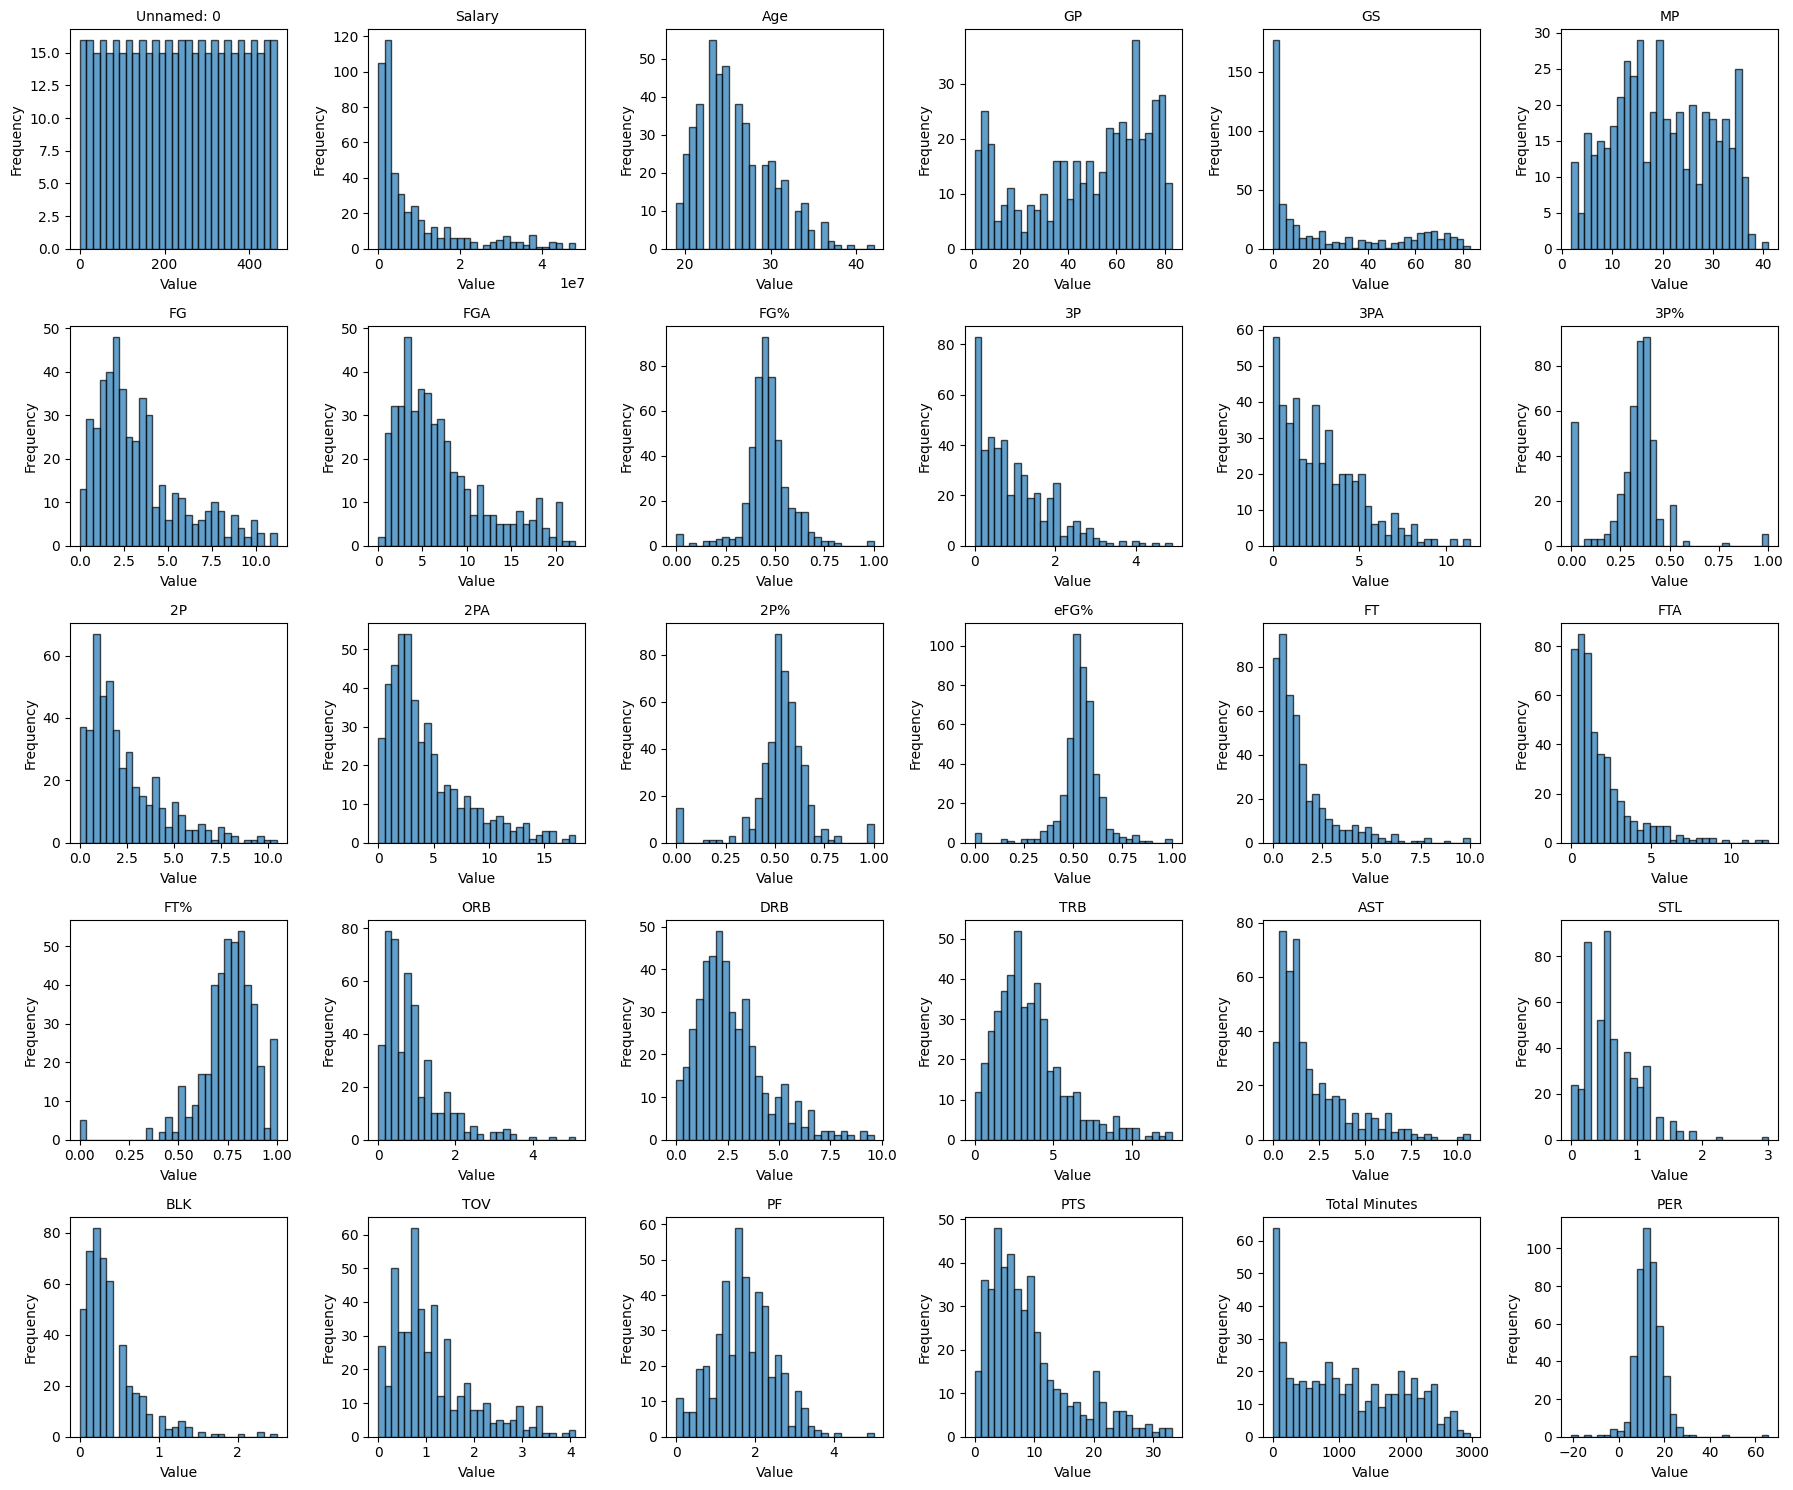

In [122]:
numericCols = dfCleaned.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(5, 6, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(numericCols[:30]):  # Show first 30 numeric columns
    axes[idx].hist(dfCleaned[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Drop closely related columns?

In [123]:
# # Select numeric columns
# numeric_df = dfCleaned.select_dtypes(include=[float, int])

# # Compute absolute correlation matrix
# corr_matrix = numeric_df.corr().abs()

# # Set threshold
# threshold = 0.95

# # Create a set to hold columns to drop
# cols_to_drop = set()

# # Iterate over correlation matrix
# for i in range(len(corr_matrix.columns)):
#     for j in range(i+1, len(corr_matrix.columns)):
#         if corr_matrix.iloc[i, j] > threshold:
#             # Add one of the two columns to drop
#             cols_to_drop.add(corr_matrix.columns[j])

# # Drop the columns from the dataframe
# numeric_df_reduced = numeric_df.drop(columns=cols_to_drop)

# print(f"Columns dropped due to high correlation (> {threshold}): {cols_to_drop}")
# print(f"Remaining columns: {numeric_df_reduced.columns.tolist()}")
# non_numeric_cols = dfCleaned.select_dtypes(exclude=[float, int])
# dfCleaned = pd.concat([non_numeric_cols, numeric_df_reduced], axis=1)


In [124]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Recomputes ratio/percentage columns For no NaNs
def safe_div(num, den):
    return np.where(den > 0, num/den,
                    np.where((den == 0) & (num == 0), 0.0, np.nan))

# Only the ones in the dataset
if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])

if {'FG','3P','FGA'}.issubset(dfCleaned):
    dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])

if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)

if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])

# Removes NaNs
ratio_cols = ['FG%', '2P%', '3P%', 'eFG%', 'TS%', '3PAr', 'FTr']
ratio_cols = [c for c in ratio_cols if c in dfCleaned.columns]

for c in ratio_cols:
    dfCleaned[c] = dfCleaned[c].clip(0, 1)

dfCleaned[ratio_cols] = dfCleaned[ratio_cols].fillna(0.0)

# when makes >0 and attempts are =0
if {'3P','3PA','3P%'}.issubset(dfCleaned.columns):
    impossible_3p = (dfCleaned['3PA'] == 0) & (dfCleaned['3P'] > 0)
    if impossible_3p.any():
        dfCleaned.loc[impossible_3p, '3P%'] = dfCleaned['3P%'].median()

# Replace any stray infs anywhere
dfCleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Cols that are not needed
dropCols = ["Player Name", "Team", "Position"]
dfNumeric = (dfCleaned.drop(columns=dropCols, errors="ignore")
                        .select_dtypes(include=[np.number]))

# Median impute is safe and won’t create huge bias like blanket zeros
dfNumeric = dfNumeric.apply(lambda s: s.fillna(s.median()))

# Check for NaNs
print("NaNs left:", int(dfNumeric.isna().sum().sum()),
      "Infs left:", int(np.isinf(dfNumeric.values).sum()))

# Scaking for AE
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfNumeric)
xTrain, xTest = train_test_split(xScaled, test_size=0.2, random_state=42)


NaNs left: 0 Infs left: 0


Question 1a

Autoencoder model

In [125]:
inputDimension = xTrain.shape[1]
encodingDimension = 2

inputDimension = xTrain.shape[1]
encodingDimension = 2

#Regularisation coefficients
lambda1 = 1e-5
lambda2 = 1e-4

encoder = models.Sequential([
    layers.Input(shape=(inputDimension,)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(encodingDimension)
])

decoder = models.Sequential([
    layers.Input(shape=(encodingDimension,)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(inputDimension, activation='linear')
])

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

Train Autoencoder

In [126]:
history = autoencoder.fit(
    xTrain, xTrain,
    epochs=50,
    batch_size=32,
    validation_data=(xTest, xTest),
    verbose=0
)

X_encoded = encoder.predict(xScaled)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


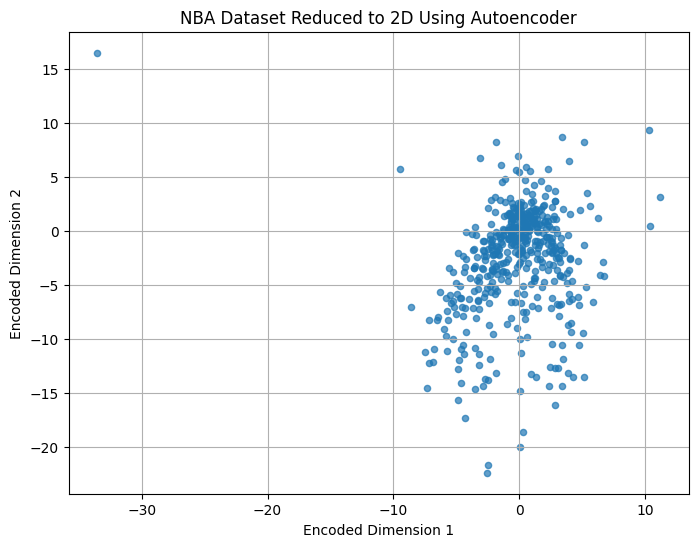

In [127]:
plt.figure(figsize=(8,6))
plt.scatter(X_encoded[:,0], X_encoded[:,1], s=20, alpha=0.7)
plt.title("NBA Dataset Reduced to 2D Using Autoencoder")
plt.xlabel("Encoded Dimension 1")
plt.ylabel("Encoded Dimension 2")
plt.grid(True)
plt.show()

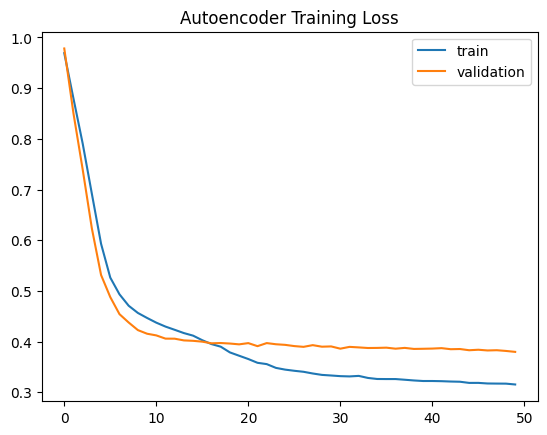

In [128]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()


In [129]:
# Get reconstructed outputs
X_reconstructed = autoencoder.predict(xScaled)

# Compute Mean Squared Error (MSE) for each sample
reconstruction_errors = np.mean(np.square(xScaled - X_reconstructed), axis=1)

# Summary statistics
print("Mean reconstruction error:", np.mean(reconstruction_errors))
print("Std of reconstruction error:", np.std(reconstruction_errors))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean reconstruction error: 0.3215459054965983
Std of reconstruction error: 0.30455915184302623


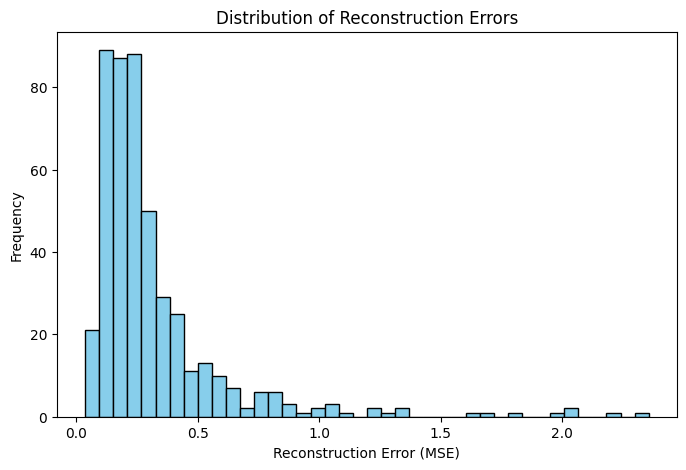

In [130]:
plt.figure(figsize=(8,5))
plt.hist(reconstruction_errors, bins=40, color='skyblue', edgecolor='k')
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.show()


In [131]:
worst_idx = np.argsort(reconstruction_errors)[-5:]
df.iloc[worst_idx][["Player Name", "PTS", "Age", "Salary"]]


,Player Name,PTS,Age,Salary
458,Jordan Schakel,1.5,24,96514
433,Louis King,20.0,23,307089
439,Chris Silva,2.0,26,211045
466,Jacob Gilyard,3.0,24,5849
437,Donovan Williams,2.0,21,239822


The reconstruction-error summary per SOM cluster provides insight into how well the autoencoder captured each group’s statistical structure.

Cluster 0 (mean ≈ 0.59, max ≈ 3.31) — highest average reconstruction error, indicating this group contains the most unusual or extreme player profiles. These are likely outliers or rare archetypes that differ strongly from the “average” player.

Cluster 1 (mean ≈ 0.32) — slightly higher than average error, suggesting moderate deviation; these players may have inconsistent stats or underperforming efficiencies.

Cluster 2 (mean ≈ 0.36) — moderate error but lower variance, meaning a tighter, more homogeneous group; probably specialized roles such as high-usage scorers.

Cluster 3 (mean ≈ 0.31) — similar to cluster 2, but smaller in size; may represent efficient specialists.

Cluster 4 (mean ≈ 0.35) — middle of the pack, balanced behavior; neither extreme nor unusual.

Cluster 5 (mean ≈ 0.25) — lowest reconstruction error and largest size (n = 176), representing the core distribution of typical players whose stats align well with the AE’s learned patterns.

Overall, the AE reconstructs most samples well, with a few niche or atypical players concentrated in cluster 0. This confirms that the SOM effectively separated common archetypes from rare ones

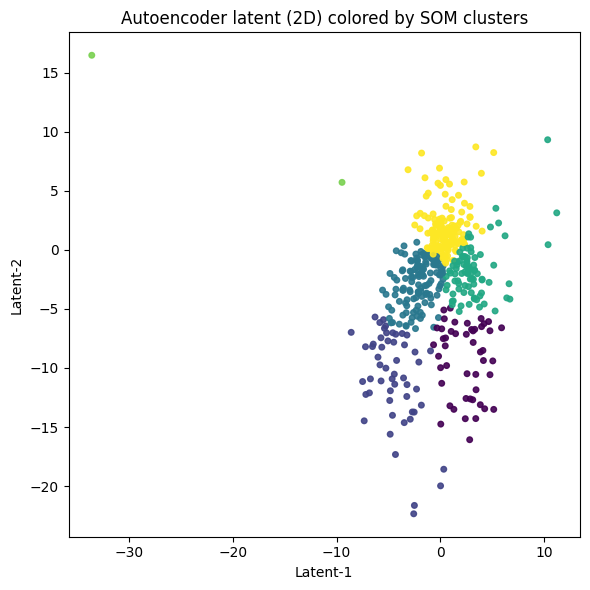

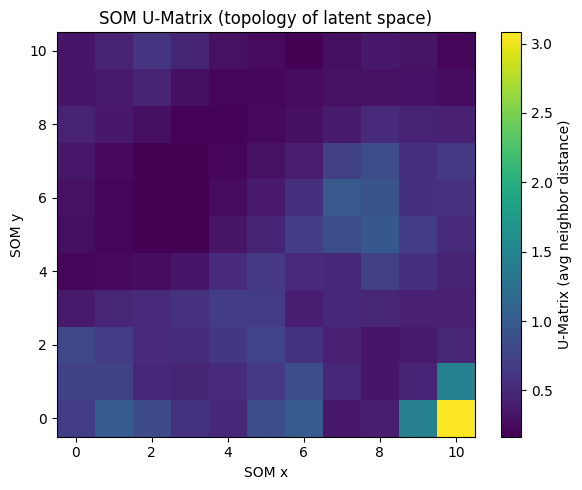

Cluster sizes: {np.int32(0): np.int64(48), np.int32(1): np.int64(53), np.int32(2): np.int64(126), np.int32(3): np.int64(83), np.int32(4): np.int64(2), np.int32(5): np.int64(155)}
         count      mean       std       min       25%       50%       75%  \
cluster                                                                      
0         48.0  0.319496  0.263900  0.090705  0.191763  0.239194  0.372179   
1         53.0  0.347441  0.204369  0.087107  0.194687  0.296348  0.467315   
2        126.0  0.296881  0.286883  0.074526  0.162263  0.234050  0.297974   
3         83.0  0.439624  0.443890  0.075231  0.175637  0.279323  0.490730   
4          2.0  1.027156  1.308671  0.101786  0.564471  1.027156  1.489841   
5        155.0  0.261042  0.211393  0.036464  0.136551  0.199412  0.306029   

              max  
cluster            
0        1.662097  
1        1.032383  
2        2.209423  
3        2.356545  
4        1.952526  
5        1.275253  


In [132]:
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Z = X_encoded.astype(np.float32)

# Scale latent for SOM
z_scaler = StandardScaler()
Zs = z_scaler.fit_transform(Z)

# SOM config
n_samples = Zs.shape[0]
tot_neurons = int(np.ceil(5*np.sqrt(n_samples)))
side = max(5, int(np.ceil(np.sqrt(tot_neurons))))
som_x, som_y = side, side

som = MiniSom(x=som_x, y=som_y, input_len=Zs.shape[1],
              sigma=1.5, learning_rate=0.5,
              neighborhood_function='gaussian', random_seed=42)

som.random_weights_init(Zs)
som.train_batch(Zs, num_iteration=2000, verbose=False)  # bump iterations if time allows

# Maps each sample to its BMU (best matching unit) on the grid
bmus = np.array([som.winner(z) for z in Zs])                  
bmu_ids = np.array([i*som_y + j for (i,j) in bmus])           

# SOM Codebook
codebook = som.get_weights().reshape(-1, Zs.shape[1])        

# K clusters
k = 6
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
neuron_labels = kmeans.fit_predict(codebook)                   

# Assign each sample the cluster of its BMU
cluster_labels = neuron_labels[bmu_ids]

plt.figure(figsize=(6,6))
plt.scatter(Z[:,0], Z[:,1], c=cluster_labels, s=16, alpha=0.9)
plt.xlabel('Latent-1'); plt.ylabel('Latent-2')
plt.title('Autoencoder latent (2D) colored by SOM clusters')
plt.tight_layout()
plt.show()


# Build U-Matrix
umatrix = np.zeros((som_x, som_y))
W = som.get_weights() 
for i in range(som_x):
    for j in range(som_y):
        neighbors = []
        for di, dj in [(1,0),(-1,0),(0,1),(0,-1)]:
            ii, jj = i+di, j+dj
            if 0 <= ii < som_x and 0 <= jj < som_y:
                neighbors.append(np.linalg.norm(W[i,j] - W[ii,jj]))
        umatrix[i,j] = np.mean(neighbors) if neighbors else 0.0

plt.figure(figsize=(6,5))
plt.imshow(umatrix.T, origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='U-Matrix (avg neighbor distance)')
plt.title('SOM U-Matrix (topology of latent space)')
plt.xlabel('SOM x'); plt.ylabel('SOM y')
plt.tight_layout()
plt.show()

# Quick cluster sizes and a peek at reconstruction error per cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

if 'reconstruction_errors' in globals():
    import pandas as pd
    tmp = pd.DataFrame({'cluster': cluster_labels, 'recon_err': reconstruction_errors})
    print(tmp.groupby('cluster')['recon_err'].describe())

Using z-score differences of each numeric feature by cluster reveals what statistically distinguishes each group. (Positive = above-average, Negative = below-average.)

Cluster 0 – “Defensive/low-impact outliers.”
Slightly below average in scoring (FG, FGA < 0), but decent FG% and above-average defensive metrics (e.g., DBPM > 0). These players might be defensive specialists or low-usage contributors.

Cluster 1 – “Inefficient low-performers.”
Strong negative values in FG%, WS, and BPM indicate low efficiency and overall impact. They likely represent bench or replacement-level players.

Cluster 2 – “High-volume offensive stars.”
Large positive z-scores in FG, FGA, 3P, and USG% (+1 to +2) with strong OBPM and WS. These are the primary scorers and focal offensive players.

Cluster 3 – “Efficient all-rounders.”
Positive FG%, WS, and BPM (~+1.3) with solid defense (DBPM > 0.9). They perform efficiently on both ends despite moderate usage,high-impact contributors.

Cluster 4 – “Average contributors.”
Most values hover near 0 (±0.3). These are balanced players with no standout traits, likely rotation regulars.

Cluster 5 – “Balanced, typical profiles.”
Slightly positive scoring and usage metrics but near-average everything else. Largest cluster; defines the dataset’s general statistical baseline.

In [133]:
import pandas as pd
Z = X_encoded  # latent
dfX = pd.DataFrame(xScaled, columns=dfCleaned.drop(columns=["Player Name","Team","Position"], errors="ignore").columns)
g = pd.DataFrame({'cluster': cluster_labels})
summary = dfX.join(g).groupby('cluster').mean()
# Compare cluster means to global mean
delta = summary - dfX.mean()
print(delta.sort_index())

         Unnamed: 0    Salary       Age        GP        GS        MP  \
cluster                                                                 
0         -0.450631  0.255227 -0.074962  0.645481  0.598665  0.438963   
1         -1.324706  1.816517  0.386736  0.633949  1.485212  1.532270   
2         -0.381428  0.106437  0.064420  0.610292  0.490572  0.694112   
3          0.690927 -0.558361 -0.073552 -0.679866 -0.698897 -0.848586   
4          1.672712 -0.779599 -0.543288 -1.885844 -0.836893 -1.821186   
5          0.511014 -0.477640 -0.114996 -0.524378 -0.706981 -0.746217   

               FG       FGA       FG%        3P  ...      TOV%      USG%  \
cluster                                          ...                       
0        0.311078  0.000919  1.210832 -0.718921  ...  0.228512 -0.297309   
1        2.046547  2.053343  0.134741  1.354112  ... -0.114157  1.646139   
2        0.338090  0.426427 -0.131196  0.690259  ... -0.096720  0.023306   
3       -0.622951 -0.736344  0.6997

Question 2.2 part for (b)

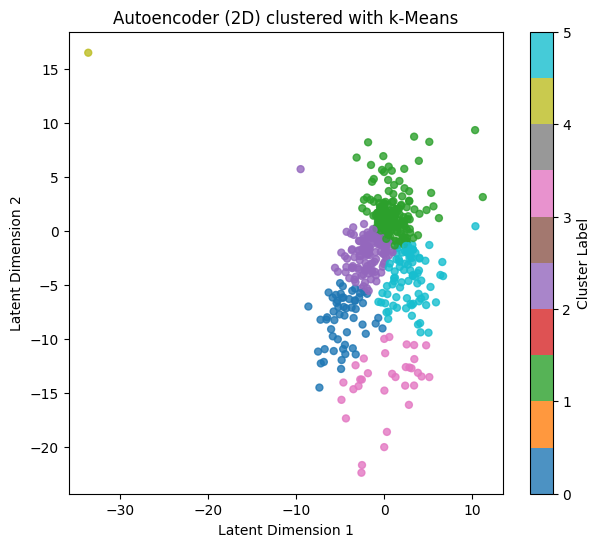

Cluster sizes: {np.int32(0): np.int64(56), np.int32(1): np.int64(175), np.int32(2): np.int64(121), np.int32(3): np.int64(33), np.int32(4): np.int64(1), np.int32(5): np.int64(81)}


In [134]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# k means
k = 6 
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_km = kmeans.fit_predict(X_encoded)

plt.figure(figsize=(7,6))
plt.scatter(X_encoded[:,0], X_encoded[:,1], c=labels_km, cmap='tab10', s=25, alpha=0.8)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Autoencoder (2D) clustered with k-Means')
plt.colorbar(label='Cluster Label')
plt.show()

import numpy as np
unique, counts = np.unique(labels_km, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))